# **Credit Card Fraud Detection**

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,roc_auc_score,roc_curve
sns.set()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [61]:
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [62]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As we already know that the data is highly unbalanced let's check the class column

In [63]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

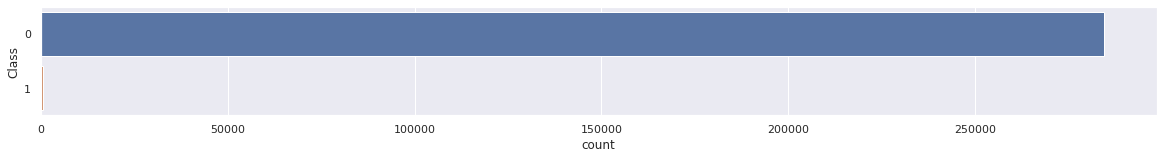

In [64]:
plt.figure(figsize=(20,2))
sns.countplot(y=data['Class'])
plt.savefig('countofdata.png')
plt.show()

As you can see by te above graph we can interpret how data is highly unbalanced

In [65]:
print(f'Percentage of data where class = 1 is : {(len(data[data.Class == 1])/ len(data[data.Class == 0]))*100}')

Percentage of data where class = 1 is : 0.17304750013189596


In [66]:
#Create train and test dataset
from sklearn.model_selection import train_test_split
X = data.drop('Class',axis=1)
y = data['Class']

In [67]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [68]:
print(f'Shape of X_train :{X_train.shape}')
print(f'Shape of X_train :{X_test.shape}')
print(f'Shape of X_train :{y_train.shape}')
print(f'Shape of X_train :{y_test.shape}')

Shape of X_train :(227845, 30)
Shape of X_train :(56962, 30)
Shape of X_train :(227845,)
Shape of X_train :(56962,)


## **Baseline models**

In [69]:
# DummyClassifier to predict only target 0
from sklearn.dummy import DummyClassifier

The DummyClassifier in sklearn is a very simple type of model that makes predictions without trying to learn from the data. It just uses a basic rule, like always predicting a specific value.

In this case, you are telling the DummyClassifier to always predict the target as "0" no matter what the input is.

Here’s what happens:

You create the classifier using DummyClassifier.
You tell it to always predict "0".
When you give it new data, it will just say "the answer is 0" every time, without looking at the data.

In [70]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train,y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [71]:
dummy_pred = dummy.predict(X_test)
#Check for the unique labels
print(f'Unique predicted labels : {np.unique(dummy_pred)}')

Unique predicted labels : [0]


In [72]:
#Check the accuracy for unique predicated labels
print(f'Accuracy for the test dataset : {accuracy_score(dummy_pred,y_test)}')

Accuracy for the test dataset : 0.9982795547909132


We got an accuracy score of 99.8% —
And without even training a model! Let’s compare this to logistic regression, an actual trained classifier.

## Logistic Regression 

Logistic Regression is a type of model used for making predictions, especially when the outcome is something like "yes" or "no" (for example, predicting if an email is spam or not spam). It tries to find the best relationship between the data (input) and the outcome (target) using a mathematical function.

Here’s a simple way to think about it:
- **Input data**: You give the model some features, like the number of words in an email, or how often it uses certain phrases.
- **Training**: The model learns from examples (data with known outcomes), figuring out what patterns lead to a "yes" or "no" outcome.
- **Prediction**: Once trained, the model uses the patterns it has learned to predict outcomes for new data. It will say how likely something is to be a "yes" or "no" based on what it has seen before.

Logistic Regression is especially good when you need to predict between two categories (binary classification).

In [73]:
#Now let's use the Logistic regression model to check the accuracy on inbalanced data set
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [74]:
#Predict the value by Logistic Regression
lr.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
#Predict on test dataset
lr_pred = lr.predict(X_test)

In [76]:
#check the accuracy
accuracy_score(lr_pred,y_test)

0.9986306660580738

In [77]:
# Checking unique values
predictions = pd.DataFrame(lr_pred)
predictions[0].value_counts()

0    56872
1       90
Name: 0, dtype: int64

As we can the Logistic regression outperformed on the Dummy Classifier.Becuase here our model identied that the 90 trascations are from class 1 i.e. fraudulent.
Let's see by using SVM and Random Forest Can we increase the Accuracy

## **Check by using Different Metrices**
* Accuracy metric is not best metric to use when evaluating imbalanced class as it can be mislead for the classification.
* Following are some metrics give us the good insights on the imbalanced dataset

    ### 1. **Confusion Metrics : ** 
    confusion metrics show the clearly classification of the predicted class vs actual class.We can also see how many data point wrongly classified.
    ### 2. **Precision : **
    We can get the precision by number of all positive classified value divided by all positive predicted value.It's measure the classifier's exactness.Low presicion indicates the high number of false positive.
    ### 3. **Recall : **
    Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.
    Unlike precision that only comments on the correct positive predictions out of all positive predictions, recall provides an indication of missed positive predictions.
    ### 4. **F1-score : **
    The F1-measure, which weights precision and recall equally, is the variant most often used when learning from imbalanced data.
    ### 5. **Classification Report : **
    All above metioned things are auto-generated in the classication report

In [78]:
from sklearn.metrics import confusion_matrix,f1_score,classification_report,recall_score

In [79]:
f1_score(y_test,lr_pred)

0.5851063829787235

In [80]:
pd.DataFrame(confusion_matrix(y_test,lr_pred))

,0,1
0,56829,35
1,43,55


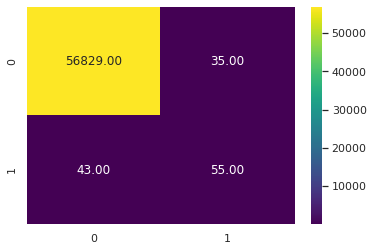

In [81]:
sns.heatmap(confusion_matrix(y_test,lr_pred),cmap='viridis',annot=True,fmt='.2f')
plt.savefig('lr.png')
plt.show()

In [82]:
recall_score(y_test,lr_pred)

0.5612244897959183

As we can see the our accuracy matrix score is near about 99% but the f1 score is only 58%

## Random Forest

**Random Forest** is like a team of decision-makers!

Imagine you have a tough question, so instead of asking one person, you ask a bunch of people, each with their own opinion. Then, you go with the answer that most people agree on. That’s basically how Random Forest works!

1. **Decision Trees**: Each person in the group is like a decision tree, which is a simple model that makes a choice based on questions like “Is it sunny or rainy?” or “Is the color red or blue?”.
   
2. **Random**: The "random" part means that each tree in the forest gets a slightly different set of questions to answer, so they don’t all make the same decision.

3. **Forest**: When you have a lot of these decision trees working together, it's called a forest. The final prediction is the one that most trees agree on.

This makes **Random Forest** really good at making accurate decisions because it reduces the chance of mistakes by relying on many trees, not just one.

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

**SVC** (Support Vector Classifier) is like drawing a line to separate two groups!

Imagine you have two groups of objects on a sheet of paper, and your goal is to draw a straight line that best separates them. **SVC** finds the perfect line (or boundary) that divides these groups in a way that keeps them as far apart as possible. This line is called a **hyperplane**.


1. **Support Vectors**: The closest points to the line from both groups are called **support vectors**. They help define exactly where the line should go.
   
2. **Maximizing the Margin**: SVC aims to place the line so that the gap (or margin) between the two groups is as wide as possible, making future predictions more accurate.

SVC is especially powerful when the data is complex and needs a clean boundary between categories. If the data isn’t easily separable, SVC can even draw more complicated shapes (using something called a kernel trick) to make better predictions.

In [84]:
random_forest = RandomForestClassifier()
svc = SVC()

In [85]:
random_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [86]:
random_forest_pred = random_forest.predict(X_test)

In [87]:
accuracy_score(random_forest_pred,y_test)

0.9995962220427653

In [88]:
f1_score(random_forest_pred,y_test)

0.8700564971751412

In [89]:
pd.DataFrame(confusion_matrix(random_forest_pred,y_test))

,0,1
0,56862,21
1,2,77


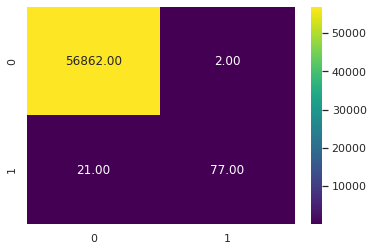

In [90]:
sns.heatmap(confusion_matrix(y_test,random_forest_pred),cmap='viridis',annot=True,fmt='.2f')
plt.savefig('random.png')
plt.show()

In [91]:
recall_score(random_forest_pred,y_test)

0.9746835443037974

As we Can see by using random forest we are getting good score and recall is also good enough.Let's print the classification report for the above

In [92]:
print(classification_report(random_forest_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56883
           1       0.79      0.97      0.87        79

    accuracy                           1.00     56962
   macro avg       0.89      0.99      0.93     56962
weighted avg       1.00      1.00      1.00     56962



## Deep Leaning Approch

**Dense** (from tensorflow.keras.layers):

A Dense layer is a fully connected layer in a neural network. Each neuron in the layer receives input from every neuron in the previous layer. You use it to create layers of neurons in your network.

**Sequential** (from tensorflow.keras.models):

This is a way to create a neural network where layers are added one after the other, step by step. It’s called "sequential" because the layers are organized in a sequence.

**Dropout** (from tensorflow.keras.layers):

Dropout is a technique used to prevent overfitting in neural networks. During training, it randomly "drops" (deactivates) some neurons, forcing the model to learn more robust features. It helps make the model generalize better.
plot_model (from tensorflow.keras.utils):

This function is used to create a visual diagram of your neural network model. It shows the layers, their connections, and the number of neurons, so you can see the structure of your model.

So:

Dense builds fully connected layers.
Sequential helps organize layers in order.
Dropout improves the model's generalization.
plot_model lets you visualize your model structure.

In [93]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model

In [94]:
model = Sequential([
    Dense(units=16,input_dim = 30,activation='relu'),
    Dense(units=24,activation='relu'),
    Dropout(0.5),
    Dense(units=20,activation='relu'),
    Dense(units=24,activation='relu'),
    Dense(1,activation='sigmoid')
])

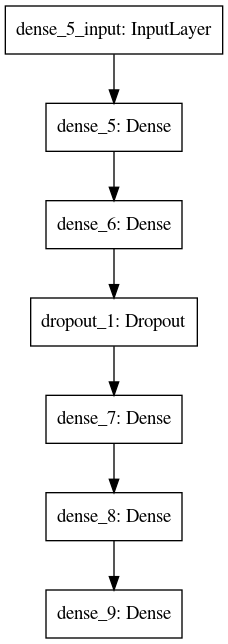

In [95]:
plot_model(model)

In [96]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                500       
_________________________________________________________________
dense_8 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 1,933
Trainable params: 1,933
Non-trainable params: 0
____________________________________________________

In [97]:
##Training of model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=15,epochs=5)

Train on 227845 samples
Epoch 1/5
227845/227845 [==============================] - 32s 141us/sample - loss: 0.6683 - accuracy: 0.9975
Epoch 2/5
227845/227845 [==============================] - 34s 147us/sample - loss: 0.0521 - accuracy: 0.9981
Epoch 3/5
227845/227845 [==============================] - 33s 143us/sample - loss: 0.0197 - accuracy: 0.9982
Epoch 4/5
227845/227845 [==============================] - 33s 145us/sample - loss: 0.0238 - accuracy: 0.9983
Epoch 5/5
227845/227845 [==============================] - 32s 142us/sample - loss: 0.0236 - accuracy: 0.9982


In [98]:
score = model.evaluate(X_test,y_test)

56962/56962 [==============================] - 2s 36us/sample - loss: 0.0127 - accuracy: 0.9983


In [99]:
y_pred = model.predict(X_test)
y_test_copy = pd.DataFrame(y_test)

In [100]:
y_pred = y_pred.astype(int)

In [101]:
pd.DataFrame(confusion_matrix(y_test,y_pred))

,0,1
0,56864,0
1,98,0


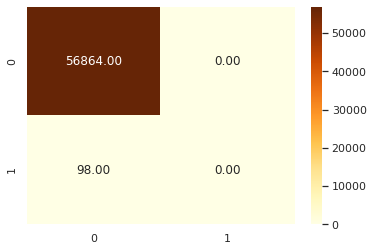

In [102]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='YlOrBr',fmt='.2f')
plt.savefig('deep.png')
plt.show()

As we can see the Type-II error is to much high for the fradulent data.As the model is biased towards the majority class.and to reduce the error model simply ignoring the fradulent trasactions

# Approaches to Handling Imbalanced Dataset:

## 1. **Resampling Technique:** 
In the Resampling technique, our main goal is to either increase the frequency of minority class or decrease the frequency of the majority class. This is done in order to obtain the same number of instances of both classes.
    Following are the few Resampling techniques:
### 1. **Random Over-sampling :**
Random Over-sampling can be defined as adding More copies of the minority class. but the oversampling choice is good when you don't have a ton of data to work.
    We will use the resampling module from scikit-learn to randomly replicate the samples from minority class.To perform oversampling it's important that we should have split the data into train and test dataset.
    Now the question will come why should we have to split before the oversampling. The answer is easy, oversampling allows us the exact same observations to be present into both the train and test dataset.


In [103]:
from sklearn.utils import resample

#Seprate the input feature and target 
X = data.drop('Class',axis=1)
y= data['Class']

In [104]:

#As told split the data into train and test dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.25)
print(f'Shape of X_train :{X_train.shape}')
print(f'Shape of X_train :{X_test.shape}')
print(f'Shape of X_train :{y_train.shape}')
print(f'Shape of X_train :{y_test.shape}')

Shape of X_train :(213605, 30)
Shape of X_train :(71202, 30)
Shape of X_train :(213605,)
Shape of X_train :(71202,)


In [105]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
83225,59741.0,-1.648591,1.228130,1.370169,-1.735542,-0.029455,-0.484129,0.918645,-0.438750,0.982144,...,-0.218076,-0.203458,-0.213015,0.011372,-0.304481,0.632063,-0.262968,-0.099863,38.42,0
52800,45648.0,-0.234775,-0.493269,1.236728,-2.338793,-1.176733,0.885733,-1.960981,-2.363412,-2.694774,...,-1.495358,-0.083066,0.074612,-0.347329,0.541900,-0.433294,0.089293,0.212029,61.20,0
21293,31579.0,1.134626,-0.774460,-0.163390,-0.533358,-0.604555,-0.244482,-0.212682,0.040782,-1.136627,...,-0.684454,-1.855269,0.171997,-0.387783,-0.062985,0.245118,-0.061178,0.012180,110.95,0
133600,80455.0,0.069514,1.017753,1.033117,1.384376,0.223233,-0.310845,0.597287,-0.127658,-0.701533,...,0.097023,0.369957,-0.219266,-0.124941,-0.049749,-0.112946,0.114440,0.066101,10.00,0
38225,39302.0,-0.199441,0.610092,-0.114437,0.256565,2.290752,4.008475,-0.123530,1.038374,-0.075846,...,-0.019733,0.165463,-0.080978,1.020656,-0.300730,-0.269595,0.481769,0.254114,22.00,0


In [106]:
#Seperate minority and majority class:
not_fraud = X[X['Class'] == 0]
fraud = X[X['Class'] == 1]
print(f'Total sample which are not fraud : {len(not_fraud)}')
print(f'Total Fraud samples : {len(fraud)}')

Total sample which are not fraud : 213226
Total Fraud samples : 379


In [107]:
#Now use the oversampling techniques
random_sampling = resample(fraud,
                          replace=True,
                           n_samples = len(not_fraud),
                           random_state = 42
                          )

#combine minority and upsample data
upsample = pd.concat([not_fraud,random_sampling])

#Check new values are balances for the both classes or not
upsample['Class'].value_counts()

1    213226
0    213226
Name: Class, dtype: int64

Now Try the logistic Regression on this data

In [108]:
X_train = upsample.drop('Class',axis=1)
y_train = upsample['Class']

lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [109]:
upsampled_pred = lr_model.predict(X_test)

In [110]:
#check for the accuracy_score
accuracy_score(y_test,upsampled_pred)

0.9562090952501334

In [111]:
#F1 score is
f1_score(y_test, upsampled_pred)

0.06197352587244284

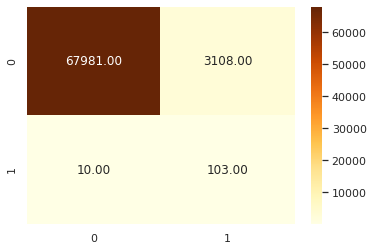

In [112]:
sns.heatmap(confusion_matrix(y_test,upsampled_pred),annot=True,fmt='.2f',cmap='YlOrBr')
plt.savefig('ligit_after_oversample.png')
plt.show()

In [113]:
print(classification_report(y_test,upsampled_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     71089
           1       0.03      0.91      0.06       113

    accuracy                           0.96     71202
   macro avg       0.52      0.93      0.52     71202
weighted avg       1.00      0.96      0.98     71202



Our accuracy score decreased after upsampling, but the model is now predicting both classes more equally, making it an improvement over our plain logistic regression above.

In [114]:
# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.Class.value_counts()

1    379
0    379
Name: Class, dtype: int64

It is performing **downsampling** of the majority class in a dataset related to fraud detection, where the target variable is likely imbalanced (e.g., more non-fraud than fraud cases). 

1. **Resample the Majority Class** (`not_fraud_downsampled`):
   - The `resample` function is used to reduce the size of the majority class (`not_fraud`), so it has the same number of samples as the minority class (`fraud`).
   - **Without replacement**: Each sample is selected only once.
   - **n_samples**: The number of samples in the downsampled majority is set to the number of samples in the fraud (minority) class.
   - **random_state**: A seed for reproducibility so that you get the same results each time you run the code.

2. **Combine Minority and Downsampled Majority**:
   - The `pd.concat` function is used to combine the downsampled majority class (`not_fraud_downsampled`) with the minority class (`fraud`). This results in a balanced dataset, where both classes have the same number of samples.

3. **Check Class Distribution**:
   - `downsampled.Class.value_counts()` is used to check how many samples are in each class (fraud vs. not fraud) after the downsampling.

This process helps to balance the dataset, ensuring that the classifier doesn't favor the majority class.

In [115]:
# trying logistic regression again with the undersampled dataset

y_train = downsampled.Class
X_train = downsampled.drop('Class', axis=1)

undersampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

undersampled_pred = undersampled.predict(X_test)

In [116]:
accuracy_score(y_test, undersampled_pred)


0.9690458133198505

In [117]:
# f1 score
f1_score(y_test, undersampled_pred)

0.08623548922056384

In [118]:
print(classification_report(y_test,undersampled_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     71089
           1       0.05      0.92      0.09       113

    accuracy                           0.97     71202
   macro avg       0.52      0.94      0.54     71202
weighted avg       1.00      0.97      0.98     71202



Let's Try with Random Forest Also,

## **Random Forest After Under-Sampling**

Random Forest after under-sampling means you first reduce the larger group (majority class) in your data so it matches the smaller group (minority class). This makes your data balanced. Then, you use Random Forest, which creates lots of decision trees. Each tree votes, and the most popular vote wins. By balancing the data first, the model gives fair attention to both groups, helping it make better predictions.

In [119]:
#Build the model for the Random Forest
random_forest_undersampled = RandomForestClassifier()
random_forest_undersampled.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [120]:
#Predict the value by using random forest
random_forest_undersampled_pred = undersampled.predict(X_test)

In [121]:
accuracy_score(y_test,random_forest_undersampled_pred)

0.9690458133198505

In [122]:
f1_score(y_test,random_forest_undersampled_pred)

0.08623548922056384

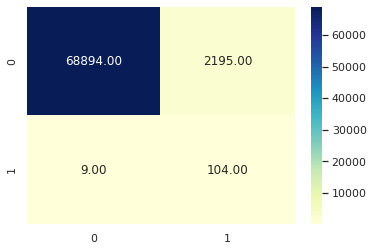

In [123]:
sns.heatmap(confusion_matrix(y_test,random_forest_undersampled_pred),annot=True,fmt='.2f',cmap='YlGnBu')
plt.savefig('rand_after_oversample.png')
plt.show()

In [124]:
print(classification_report(y_test,random_forest_undersampled_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     71089
           1       0.05      0.92      0.09       113

    accuracy                           0.97     71202
   macro avg       0.52      0.94      0.54     71202
weighted avg       1.00      0.97      0.98     71202



# **Generate Synthetic Samples:**

# **SMOTE :**
A technique is similar to upsampling is to create synthetic samples. Here we use SMOTE (Synthetic Minority Oversampling Technique) technique.
SMOTE (Synthetic Minority Oversampling Technique) works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space, and drawing a new sample at a point along that line.
By above we can easily understand the SMOTE working is similar to the nearest neighbor algorithm. Yeah you are right!! SMOTE uses the nearest neighbor algorithm to generate new and synthetic data we can use to train our model.

In [125]:
#import the libaray for SMOTE
from imblearn.over_sampling import SMOTE

# Separate input features and target
y = data["Class"]
X = data.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=27,sampling_strategy=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

Using TensorFlow backend.


In [126]:
smote_logistic = LogisticRegression()
smote_logistic.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [127]:
smote_pred = smote_logistic.predict(X_test)

In [128]:
# Checking accuracy
accuracy_score(y_test, smote_pred)

0.9804431024191567

In [129]:
# f1 score
f1_score(y_test, smote_pred)

0.13643410852713178

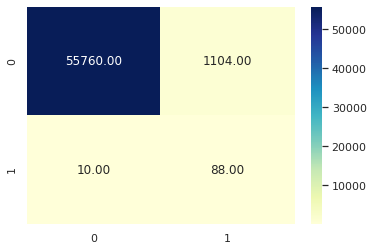

In [130]:
sns.heatmap(confusion_matrix(y_test,smote_pred),annot=True,fmt='.2f',cmap='YlGnBu')
plt.savefig('rand_after_oversample.png')
plt.show()

In [131]:
smote_random_forest = RandomForestClassifier()
smote_random_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [132]:
smote_rand_pred = smote_random_forest.predict(X_test)

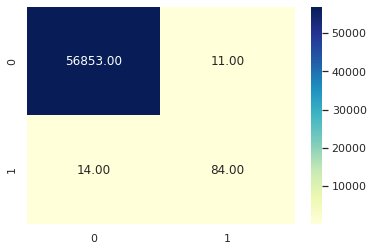

In [133]:
sns.heatmap(confusion_matrix(y_test,smote_rand_pred),annot=True,fmt='.2f',cmap='YlGnBu')
plt.savefig('rand_after_smote.png')
plt.show()

In [134]:
accuracy_score(y_test,smote_rand_pred)

0.9995611109160493

In [135]:
#F1_score is
f1_score(y_test,smote_rand_pred)

0.8704663212435233

In [136]:
print(classification_report(y_test,smote_rand_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.86      0.87        98

    accuracy                           1.00     56962
   macro avg       0.94      0.93      0.94     56962
weighted avg       1.00      1.00      1.00     56962

